# Relax Inc. Data Science Challenge

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
sns.set(style="whitegrid")

#### Get users data into a dataframe

In [3]:
users = pd.read_csv('takehome_users.csv', encoding='latin-1')
print(users.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB
None


#### Let's see what's inside the data

In [4]:
print(users.head(5))

   object_id        creation_time               name  \
0          1  2014-04-22 03:53:30     Clausen August   
1          2  2013-11-15 03:45:04      Poole Matthew   
2          3  2013-03-19 23:14:52  Bottrill Mitchell   
3          4  2013-05-21 08:09:28    Clausen Nicklas   
4          5  2013-01-17 10:14:20          Raw Grace   

                        email creation_source  last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
2  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   
3   NicklasSClausen@yahoo.com    GUEST_INVITE                1.369210e+09   
4          GraceRaw@yahoo.com    GUEST_INVITE                1.358850e+09   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11   
1                         0                           0       1   

In [6]:
session = pd.read_csv('takehome_user_engagement.csv', encoding='latin-1')
print(session.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB
None


In [7]:
session.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


## Data Wrangling and Exploratary Data Analysis

In [8]:
session['time_stamp'] = pd.to_datetime(session['time_stamp']) - pd.to_timedelta(7, unit='d')
session.head()

,time_stamp,user_id,visited
0,2014-04-15 03:53:30,1,1
1,2013-11-08 03:45:04,2,1
2,2013-11-22 03:45:04,2,1
3,2013-12-02 03:45:04,2,1
4,2013-12-18 03:45:04,2,1


### Calculate weekly session by user and get maximum no of session in a day for user as a time series object.

In [62]:
ses_stats = pd.Series([])
days = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']
for day in days:
    k = session.groupby(['user_id', pd.Grouper(key='time_stamp', freq='W-' + day)])['visited'].count().reset_index().sort_values('user_id')
    k = k.groupby('user_id')['visited'].max()
    if len(ses_stats) == 0:
        ses_stats = k
    else:
        ses_stats = pd.DataFrame([ses_stats, k]).max()

ses_stats.head()

user_id
1    1
2    3
3    1
4    1
5    1
dtype: int64

#### Invited users

In [63]:
invited_users = users[users['invited_by_user_id'].notnull()]['invited_by_user_id'].astype('int')
invited_users = pd.Series(1, index=invited_users)

#### Daily Adopted user based on no of session


In [11]:
users['adopted_user'] = users['object_id'].apply(lambda x: 1 if x in ses_stats and ses_stats[x] >= 3 else 0)
users['adopted_user'].value_counts()
users['invited'] = users['object_id'].apply(lambda x: 1 if x in invited_users else 0)

###  Adopted user frequency by source of creation

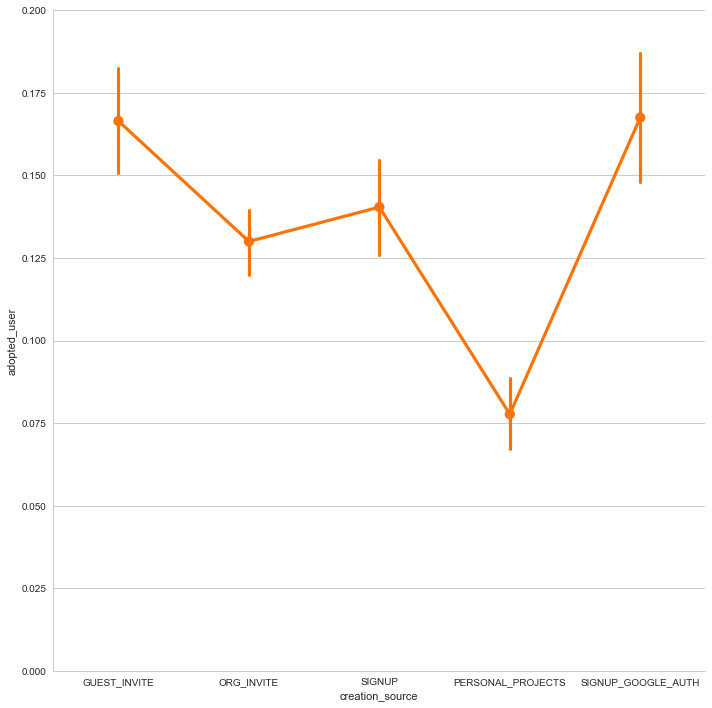

In [25]:
g = sns.PairGrid(data=users, x_vars=['creation_source'], y_vars='adopted_user', size=10)
g.map(sns.pointplot, color=sns.xkcd_rgb["orange"])
g.set(ylim=(0,.2))

### Adopted user and not adopted user count

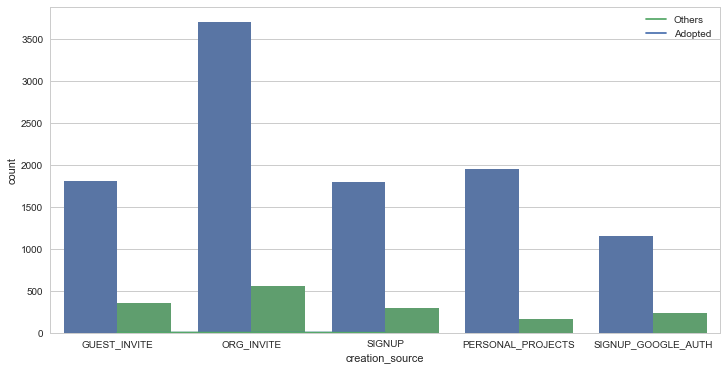

In [40]:
# plot
plt.figure(figsize=(12,6))
sns.countplot(x='creation_source', data=users, hue='adopted_user')

adopted, = plt.plot([1,2,3], label='Adopted')
no_adopted, = plt.plot([3,2,1],  label='Others')
plt.legend([no_adopted, adopted], ['Others', 'Adopted'])

###  Adopted user frequency by invitation

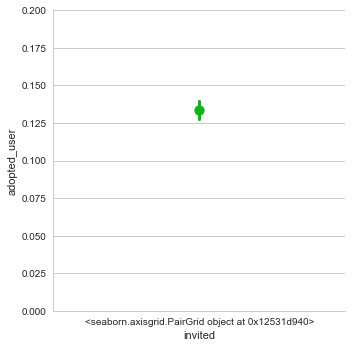

In [67]:
# plot
g = sns.PairGrid(data=users, x_vars=['invited'], y_vars='adopted_user', size=5)
g.map(sns.pointplot, color=sns.xkcd_rgb["green"])
g.set(ylim=(0, 0.2))
title = 'Relationship between Email & User Adoption Ratio'
plt.title(title,fontsize = 12)
plt.xlabel("Email")
plt.ylabel("Percentage%")

In [42]:
def stacked_bar(feature):
    ctab = pd.crosstab([users[feature]], users['adopted_user'], dropna=False).apply(lambda x: x/x.sum(), axis=1)
    ctab.plot(kind='bar', stacked=True, legend=False)

In [43]:
users['email'] = users['email'].apply(lambda x: x[x.find('@')+1:])
major_domains = ['gmail.com', 'yahoo.com', 'jourrapide.com', 'cuvox.de', 'gustr.com', 'hotmail.com']
users['email'] = users['email'].apply(lambda x: 'other' if x not in major_domains else x[:x.find('.')])

### Email type for user adoption ratio.

Text(0,0.5,'Percentage%')

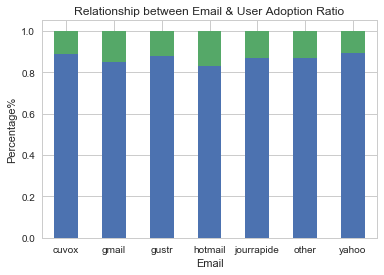

In [73]:
# plot 
stacked_bar('email')
plt.xticks(rotation=360)
title = 'Relationship between Email & User Adoption Ratio'
plt.title(title,fontsize = 12)
plt.xlabel("Email")
plt.ylabel("Percentage%")

<div class="span10 alert alert-info">
The chart above shows that users having hotmail and gmail are more likely to become adopted users. On the contrary yahoo users are unlikely to become adopted users.
</div>

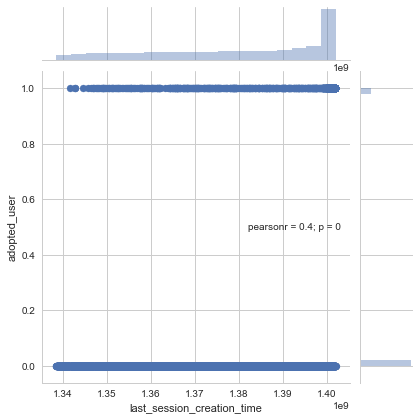

In [75]:
sns.jointplot(x='last_session_creation_time', y='adopted_user', data=users)


In [46]:
#reset index, drop the name variable and get a count grouped by email
df = users.set_index('object_id')
df = df.drop('name', axis=1)
df['email'].value_counts().head(10)

gmail         3562
yahoo         2447
jourrapide    1259
cuvox         1202
other         1186
gustr         1179
hotmail       1165
Name: email, dtype: int64

In [47]:
df = df.drop('invited_by_user_id', axis=1)
df['org_id'].value_counts().shape
df[df['adopted_user'] == 1]['org_id'].value_counts().shape

(400,)

In [48]:
df = df.drop('org_id', axis=1)
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['month'] = df['creation_time'].apply(lambda x: x.month)
df['year'] = df['creation_time'].apply(lambda x: x.year)

In [49]:
df = df.drop('creation_time', axis=1)
df['year'] = df['year'].astype('str')
df['month'] = df['month'].astype('str')

In [50]:
df = pd.get_dummies(df, prefix='is')
df['last_session_creation_time'] = df['last_session_creation_time'].fillna(df['last_session_creation_time'].mean())

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 32 columns):
last_session_creation_time                              12000 non-null float64
opted_in_to_mailing_list                                12000 non-null int64
enabled_for_marketing_drip                              12000 non-null int64
adopted_user                                            12000 non-null int64
is_cuvox                                                12000 non-null uint8
is_gmail                                                12000 non-null uint8
is_gustr                                                12000 non-null uint8
is_hotmail                                              12000 non-null uint8
is_jourrapide                                           12000 non-null uint8
is_other                                                12000 non-null uint8
is_yahoo                                                12000 non-null uint8
is_GUEST_INVITE                           

In [76]:
X, y = df.drop('adopted_user', axis=1), df['adopted_user']

In [77]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.85, test_size=0.15, stratify=y)


In [78]:
# This is a classification probelm to identify if a user will be converted as adopted user or not. 
# Trying Gradient boost classifier 

classifier = GradientBoostingClassifier(verbose=True)
classifier.fit(train_X, train_y)
classifier.score(test_X, test_y)

      Iter       Train Loss   Remaining Time 
         1           0.6611            1.43s
         2           0.5946            1.55s
         3           0.5468            2.54s
         4           0.5103            2.22s
         5           0.4820            1.99s
         6           0.4565            1.92s
         7           0.4362            1.76s
         8           0.4193            1.65s
         9           0.4046            1.58s
        10           0.3861            1.50s
        20           0.3049            1.24s
        30           0.2742            1.02s
        40           0.2360            0.87s
        50           0.2197            0.71s
        60           0.2053            0.56s
        70           0.1958            0.42s
        80           0.1871            0.28s
        90           0.1802            0.14s
       100           0.1742            0.00s


0.97333333333333338

In [79]:
confusion_matrix(test_y, classifier.predict(test_X))


array([[1548,   12],
       [  36,  204]])

In [57]:
classifier.feature_importances_.shape


(31,)

In [58]:
features = pd.Series(classifier.feature_importances_, index=X.columns)


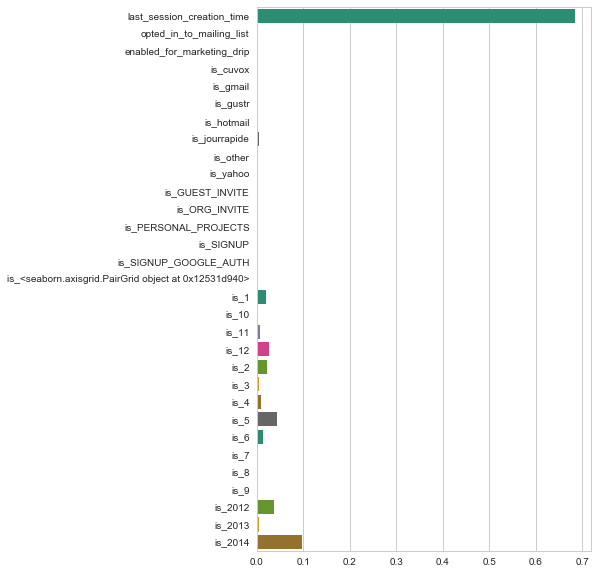

In [59]:
plt.figure(figsize=(6,10))
sns.barplot(y=X.columns, x=classifier.feature_importances_, palette = 'Dark2')

## Summary

The results from above analysis and modeling performed above suggests that most important feature in this data is last session creation time. It accounts for almost 70%. All the other features have close to zero importance and will not help in defining the target variable.
